In [10]:
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import xml.etree.ElementTree as et
import zeep
from zeep.cache import SqliteCache

In [ ]:
fromDate, ToDate = "2024-01-01", "2024-12-31"

dates = pd.date_range(start=fromDate, end=ToDate, freq="MS").strftime('%Y-%m-%d')

df_sales = pd.DataFrame({
    'date':dates,
    'sales': [5350, 5450, 5500, 4500, 4400, 3900, 3800, 4000, 4500, 4900, 5000, 5500]
})

df_sales["date"] = pd.to_datetime(df_sales["date"]) # переводим значения в столбце в формат datetime
df_sales = df_sales.set_index(keys="date").sort_index() # задаём столб "date" индексом dataframe'a и сортируем

In [ ]:
def get_cbr_key_rate(fromDate, ToDate):
    """Собираем dataframe с ключевой ставкой в промежутке дат.
    ToDate должен принимать значения с последним днем месяца (30,31)."""
    service_url = "https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?WSDL"
    transport = zeep.Transport(cache=SqliteCache())
    cbr_client = zeep.Client(wsdl=service_url, transport=transport)
    response = cbr_client.service.KeyRateXML(fromDate=fromDate, ToDate=ToDate)
    df = pd.read_xml(StringIO(et.tostring(element=response, encoding='unicode')))
    df["DT"] = df["DT"].str.replace(pat="T00:00:00+03:00", repl="", regex=False)
    df["DT"] = pd.to_datetime(df["DT"])
    df = df.set_index(keys="DT").sort_index()
    df = df.groupby(df.index.to_period('M')).agg(lambda x: x.mode().iloc[0])
    df.index = df.index.to_timestamp()
    return df

key_rate = get_cbr_key_rate(fromDate, ToDate)
def key_rate_and_sales(key_rate):
    '''Создаём dataframe с продажами, ставкой и датой'''
    df = pd.DataFrame(data = {"sales": df_sales["sales"], "rate": key_rate["Rate"]}, index=key_rate.index)
    return df

Forcing soap:address location to HTTPS
Forcing soap:address location to HTTPS


In [5]:
sales_rates_2024 = key_rate_and_sales(key_rate)
sales_rates_2024

,sales,rate
DT,,
2024-01-01,5350,16.0
2024-02-01,5450,16.0
2024-03-01,5500,16.0
2024-04-01,4500,16.0
2024-05-01,4400,16.0
2024-06-01,3900,16.0
2024-07-01,3800,16.0
2024-08-01,4000,18.0
2024-09-01,4500,19.0


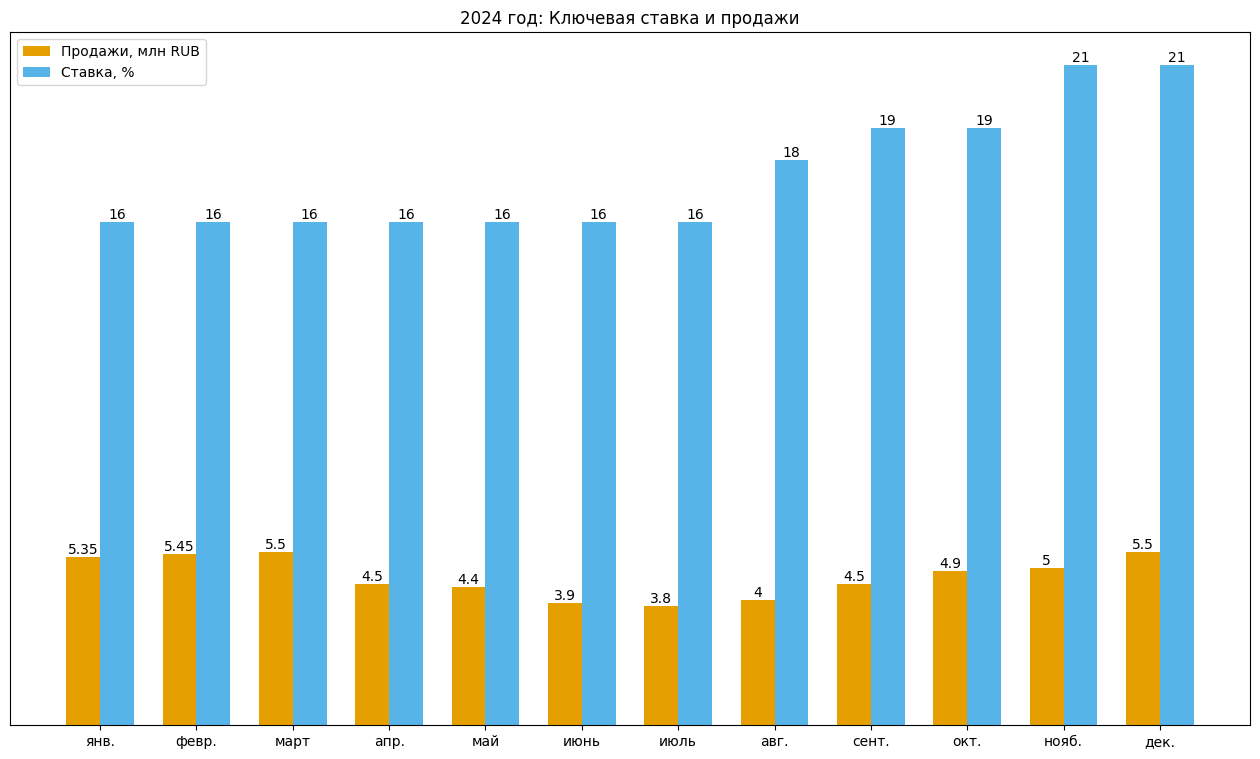

In [6]:
months = ("янв.", "февр.", "март", "апр.", "май", "июнь", "июль", "авг.", "сент.", "окт.", "нояб.", "дек.")
bar_width = 0.35

fig, ax = plt.subplots(figsize = (16, 9))

sales_bar = ax.bar(x = np.arange(len(months)) - bar_width/2, height = np.array(sales_rates_2024["sales"]/1000),
                    width = bar_width, label = "Продажи, млн RUB", color = "#E69F00")

rate_bar = ax.bar(x = np.arange(len(months)) + bar_width/2, height = np.array(sales_rates_2024["rate"]),
                width = bar_width, label = "Ставка, %", color = "#56B4E9")

ax.set_xticks(np.arange(len(months)))
plt.yticks([])
ax.set_xticklabels(months)
ax.legend()
ax.set_title("2024 год: Ключевая ставка и продажи")
ax.bar_label(container=sales_bar)
ax.bar_label(container=rate_bar)
plt.show()

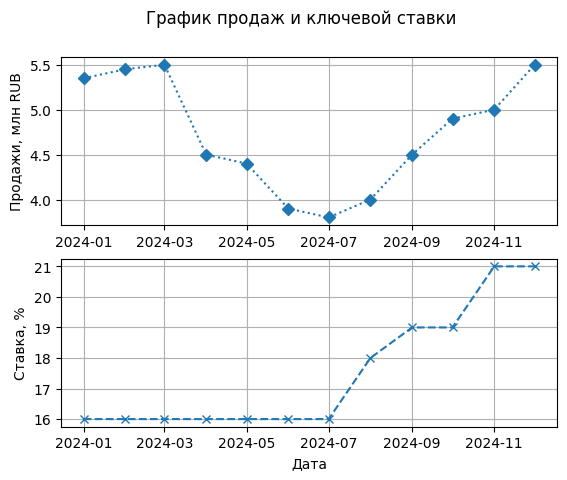

In [7]:
fig2, (ax1, ax2) = plt.subplots(2, 1)
fig2.suptitle('График продаж и ключевой ставки')

ax1.plot(sales_rates_2024["sales"]/1000, marker='D', linestyle = ':')
ax1.set_ylabel("Продажи, млн RUB")
ax1.grid()

ax2.plot(sales_rates_2024["rate"], marker='x', linestyle = '--')
ax2.set_xlabel('Дата')
ax2.set_ylabel('Ставка, %')
ax2.grid()

plt.show()

Исследуем зависимость между объемами продаж📊 и ключевой ставкой📈📉.

Для этого я задам нулевую и альтернативную гипотезу, H_0 и H_1 соответсвенно, и проверю корреляцию между продажами и ставкой.

H_0: Зависимости между объемами продаж и ключевой ставкой НЕ существует.

H_1: Зависимость между продажами и ставкой есть.

Выбераю уровень значимости равный 0.05 для оценки истинности нулевой гипотезы.

In [22]:
alpha = 0.05
cor_coef, p_value = stats.pearsonr(x=sales_rates_2024['rate'], y=sales_rates_2024["sales"])
print(f"Уровень значимости равен {alpha}. P-значение - {np.round(a=p_value, decimals=2)}; коеффициент корреляции - {np.round(a=cor_coef, decimals=2)}")

Уровень значимости равен 0.05. P-значение - 0.44; коеффициент корреляции - 0.25


Положительный коэффициент корреляции значит, что по мере роста ключевой ставки растут объемы продаж.

Значение в 0.25 по шкале от 0 до 1 говорит о незначительной связи между данными показателями нашей выборки данных.

При P-значении равном 0.44 и уровне значимости 0.05 мы не отвергаем нулевую гипотезу. Это говорит о том, что данная связь может быть результатом случайных колебаний данных. 

В итоге, зависимости между ключевой ставкой и объемами продаж нет.